# Sentiment Classification Using RNNs

* Given the IMDB Movie Review Dataset, create an RNN model that predicts whether the given review is negative or positive.
* You need to create your Dataset, Dataloader and Model. Keep your code modular and avoid hardcoding any parameter. This will allow you to experiment more easily.
* Plot graphs for loss and accuracy for each epoch of a training loop. Try using wandb for logging training and validation losses, accuracies.
* Use tqdm to keep track of the status of the training loop for an epoch

### 1. RNN Model
#### 1.1 Build a Dataset from the IMDB Movie Review Dataset by taking reviews with word count between 100 and 500. Perform text processing on the movie reviews and create a word to index mapping for representing any review as a list of numbers.
#### 1.2 Create Dataloaders for the train, test and validation datasets with appropriate batch sizes.
#### 1.3 Create the Model class for the RNN Model. Create functions for running model training and testing.

In [41]:
!pip install datasets torchmetrics

In [42]:
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import Accuracy

from tqdm import tqdm

In [43]:
SEED = 1234

# set seed for all possible random functions to ensure reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True

In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [45]:
# load the IMDB review dataset. You can take the dataset from Huggingface
imdb_dataset = load_dataset("imdb")

  0%|          | 0/3 [00:00<?, ?it/s]

In [46]:
# Split the train set into train and validation in 80-20 split. Use the labels
# to ensure that the ratio of the samples from each label is maintained

print(imdb_dataset)

from datasets import load_dataset
from sklearn.model_selection import train_test_split
import pandas as pd

train_df = pd.DataFrame(imdb_dataset["train"])

# Splitting the data based on labels
labels = train_df["label"].unique()
train_split = []
valid_split = []
for label in labels:
    label_df = train_df[train_df["label"] == label]
    train_data, valid_data = train_test_split(label_df, test_size=0.2, random_state=42)
    train_split.append(train_data)
    valid_split.append(valid_data)

# Concatenate the splits for each label
train_split = pd.concat(train_split)
valid_split = pd.concat(valid_split)

# Shuffle the splits
train_split = train_split.sample(frac=1, random_state=42).reset_index(drop=True)
valid_split = valid_split.sample(frac=1, random_state=42).reset_index(drop=True)

# Convert back to datasets.DatasetDict format
imdb_dataset["train"] = train_split
imdb_dataset["valid"] = valid_split

# Print the number of samples in each set
print("Train set size:", len(imdb_dataset["train"]))
print("Validation set size:", len(imdb_dataset["valid"]))

print(imdb_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
Train set size: 20000
Validation set size: 5000
DatasetDict({
    train:                                                     text  label
    0      Alain Resnais films are uncanny in the way tha...      1
    1      I was very disappointed in this movie. Plotwis...      0
    2      This reboot is like a processed McDonald's mea...      0
    3      Bernard Rapp passed away last year and was a v...      0
    4      I was initially forced to attend by my wife as...      1
    ...                                                  ...    ...
    19995  Glacier Fox is one of the most heartrending an...      1
    19996  This movie is a very realistic view of a polic...      1
    19997  Matt Cordell is ba

In [47]:

  # Perform text preprocessing:
  # 1. Removing numbers OR replace them with "num" token
  # 2. Convert all characters to lowercase.
  # 3. Tokenize the sentence into words
  # You can use RegexpTokenizer from NLTK.

  # You will experiment with stemming/lemmatization down the line
  # so you can skip that for now

from nltk.tokenize import RegexpTokenizer

def clean(text, tokenizer):
    # Initialize the RegexpTokenizer with a pattern to match words
    tokenizer = RegexpTokenizer(r'\w+')

    # Tokenize the text into words
    tokens = tokenizer.tokenize(text.lower())

    # Replace numbers with "num" token
    tokens = ['num' if token.isdigit() else token for token in tokens]

    # Join the tokens back into a single string
    cleaned_text = ' '.join(tokens)

    return cleaned_text


In [48]:
clean("This IS 1 example sentence", RegexpTokenizer(r'\w+'))
# Tokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [49]:
# create a word to index dictionary so that each word in the training set
# has a number associated with it. This allows to represent each sentence
# as a series of numbers. Start the index with 1 instead of 0. The number
# 0 will be used to denote padding, so that each sentence can have the
# same length.
# Keep track of the index since it will be used for representing new words
# that were not part of the training vocabulary.
# Also, make sure to not create dictionary on sentences with word count
# not within the range

# Create a word to index dictionary
from tqdm import tqdm

def get_word2idx(corpus, tokenizer, min_word_count=1, max_word_count=100):
    word2idx = {}
    idx = 1
    for sentence in tqdm(corpus, total=len(corpus), desc="Creating word2idx"):
        sentence = clean(sentence,RegexpTokenizer(r'\w+'))
        # Tokenize the sentence
        tokens = tokenizer.tokenize(sentence.lower())
        # Check if the word count of the sentence is within the specified range
        if min_word_count <= len(tokens) <= max_word_count:
            for token in tokens:
                if token not in word2idx:
                    word2idx[token] = idx
                    idx += 1
    return idx, word2idx

# Example usage:
# Assuming train_corpus is a list of sentences from the training set
train_corpus = imdb_dataset['train']['text']
tokenizer = RegexpTokenizer(r'\w+')
max_word_count = 100  # Maximum word count for a sentence
min_word_count = 1  # Minimum word count for a sentence
idx, word2idx = get_word2idx(train_corpus, tokenizer, min_word_count, max_word_count)

# Printing the word-to-index dictionary
# print(word2idx)


Creating word2idx: 100%|██████████| 20000/20000 [00:04<00:00, 4572.06it/s]


In [50]:
# Build a Dataset object to store each sentence as a tensor of numbers
# along with the label. Make sure to add padding so that the tensor
# for each sentence is of the same length. This will allow us to train
# the model in batches.

import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm

class IMDBDataset(Dataset):
    def __init__(self, sentences, labels, word2idx, minlen: int = 100, maxlen: int = 500):
        self.count = 0  # total sentences you finally pick



        input_data = []
        target_data = []

        tokenizer = RegexpTokenizer(r'\w+')

        for sentence, label in tqdm(zip(sentences, labels), total=len(sentences), desc="Processing Reviews"):
              
            tokens = clean(sentence, tokenizer)
            # drop sentences greater than maxlen or less than minlen
            if minlen <= len(tokens) <= maxlen:
                # replace words with their index
                indexed_sentence = [word2idx[token] for token in tokens if token in word2idx]
                input_data.append(torch.tensor(indexed_sentence))
                target_data.append(label)
                self.count += 1

        # pad the sentences up to maxlen
        self.inputs = pad_sequence(input_data, batch_first=True)
        self.targets = torch.tensor(target_data)

    def __len__(self) -> int:
        return self.count

    def __getitem__(self, index: int):
        return self.inputs[index], self.targets[index]




In [51]:
# Create the train dataset using the word2idx dictionary built using the train set
train_ds = IMDBDataset(imdb_dataset["train"]["text"],imdb_dataset["train"]["label"], word2idx, minlen=100, maxlen=500)

# Create the validation dataset using the word2idx dictionary built using the train set
valid_ds = IMDBDataset(imdb_dataset["valid"]["text"],imdb_dataset["valid"]["label"], word2idx, minlen=100, maxlen=500)

# Create the test dataset using the word2idx dictionary built using the train set
test_ds = IMDBDataset(imdb_dataset["test"]["text"],imdb_dataset["test"]["label"], word2idx, minlen=100, maxlen=500)


Processing Reviews: 100%|██████████| 25000/25000 [00:03<00:00, 7189.47it/s]


In [52]:
len(train_ds), len(valid_ds), len(test_ds)

(2028, 536, 2685)

In [53]:
# create dataloaders using the dataset
params = {
    'batch_size':32,
    'shuffle': True,
    'num_workers': 2
}

train_dataloader = DataLoader(train_ds, **params)
valid_dataloader = DataLoader(valid_ds, **params)
test_dataloader = DataLoader(test_ds, **params)

In [54]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(RNNModel, self).__init__()
        # Define the layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Run forward pass through the model
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        # Pick the last output
        output = output[:, -1, :]
        logits = self.fc(output)
        return logits


In [55]:
hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5
num_classes = 2
vocab_size = len(word2idx) + 1
# create the model
model = RNNModel(vocab_size, hidden_size, embedding_dim, num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# create optimizer

print(model)

RNNModel(
  (embedding): Embedding(12345, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [63]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []
    val_acc = []
    val_accuracy = 0.0
    best_val_accuracy = 0.0
    best_model_state_dict = None

    for epoch in range(epochs):
        ## TRAINING STEP
        model.train()
        train_loss = 0.0
        total_train_samples = 0

        for input_batch, output_batch in tqdm(train_loader, total=len(train_loader), desc="Training"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(input_batch)
            loss = criterion(outputs, output_batch)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * input_batch.size(0)
            total_train_samples += input_batch.size(0)

        train_loss /= total_train_samples
        train_losses.append(train_loss)

        ## VALIDATION STEP
        model.eval()
        val_loss = 0.0
        correct_predictions = 0
        total_val_samples = 0

        with torch.no_grad():
            for input_batch, output_batch in tqdm(valid_loader, total=len(valid_loader), desc="Validation"):
                input_batch, output_batch = input_batch.to(device), output_batch.to(device)

                # Forward pass
                outputs = model(input_batch)
                loss = criterion(outputs, output_batch)

                val_loss += loss.item() * input_batch.size(0)

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == output_batch).sum().item()
                total_val_samples += input_batch.size(0)

        val_loss /= total_val_samples
        val_losses.append(val_loss)

        # Calculate validation accuracy
        val_accuracy = correct_predictions / total_val_samples
        val_acc.append(val_accuracy)

        # Log metrics
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Store best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state_dict = model.state_dict()

    return train_losses, val_losses, val_accuracy, val_acc,best_model_state_dict


In [57]:
# Create a model testing loop


def test_model(model, test_loader, criterion, device):
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    model.eval()

    with torch.no_grad():
        for input_batch, output_batch in tqdm(test_loader, total=len(test_loader), desc="Testing"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)

            # Forward pass
            outputs = model(input_batch)
            loss = criterion(outputs, output_batch)

            test_loss += loss.item() * input_batch.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == output_batch).sum().item()
            total_samples += input_batch.size(0)

    test_loss /= total_samples
    test_accuracy = correct_predictions / total_samples

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return test_loss, test_accuracy



In [64]:
# train the model
# Assuming you have defined your train_loader and val_loader earlier

# Train the model
train_losses, val_losses, val_accuracy,val_acc, best_model_state_dict = train_model(
    model=model,
    train_loader=train_dataloader,
    valid_loader=valid_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=epochs
)


Validation: 100%|██████████| 17/17 [00:00<00:00, 116.46it/s]


Epoch 1/5, Train Loss: 0.6929, Validation Loss: 0.7257, Validation Accuracy: 0.5578


Validation: 100%|██████████| 17/17 [00:00<00:00, 116.35it/s]


Epoch 2/5, Train Loss: 0.6957, Validation Loss: 0.6963, Validation Accuracy: 0.5578


Validation: 100%|██████████| 17/17 [00:00<00:00, 98.38it/s]


Epoch 3/5, Train Loss: 0.6929, Validation Loss: 0.6876, Validation Accuracy: 0.5578


Validation: 100%|██████████| 17/17 [00:00<00:00, 107.76it/s]


Epoch 4/5, Train Loss: 0.6916, Validation Loss: 0.7072, Validation Accuracy: 0.5597


Validation: 100%|██████████| 17/17 [00:00<00:00, 113.20it/s]

Epoch 5/5, Train Loss: 0.6996, Validation Loss: 0.6882, Validation Accuracy: 0.5578


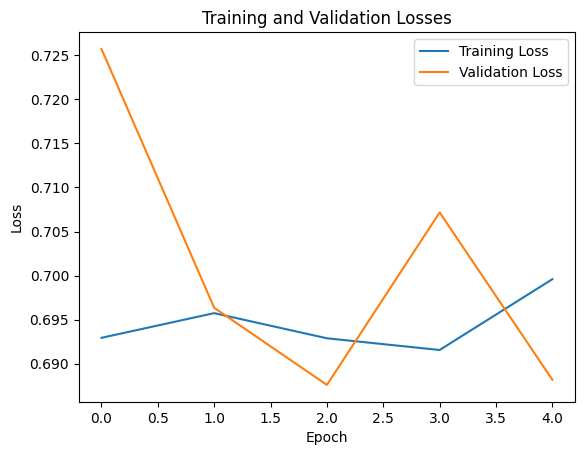

[0.6929312933831525, 0.6957336750021113, 0.6928792537081642, 0.6915503639206143, 0.6995866821832676]
[0.7257251098974428, 0.6963420581461778, 0.6875852435382445, 0.70716408918153, 0.688174307346344]


In [65]:
# plot training and validation losses
# plot training and validation losses

import matplotlib.pyplot as plt

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

print(train_losses)
print(val_losses)

0.5578358208955224


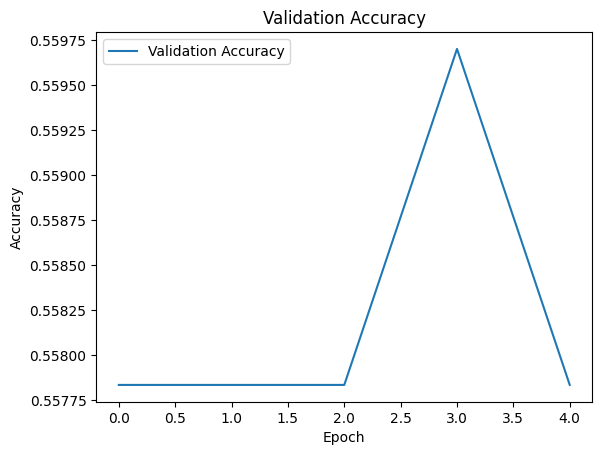

In [66]:
# plot validation accuracy# plot validation accuracy
print(val_accuracy)
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

In [67]:
# find the classification accuracy on test set

test_loss, test_accuracy = test_model(
    model=model,
    test_loader=test_dataloader,
    criterion=criterion,
    device=device
)

print(f"Test Accuracy: {test_accuracy:.4f}")


Testing: 100%|██████████| 84/84 [00:00<00:00, 151.04it/s]

Test Loss: 0.6907, Test Accuracy: 0.5359
Test Accuracy: 0.5359


#### 1.2 Incorporate stemming/lemmatization when doing text preprocessing using the NLTK library. What changes do you observe in accuracy ?

In [103]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()


def clean_lemm(text, tokenizer):
    text = re.sub(r'\d+', 'num', text)
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

class IMDBDataset_lemm(Dataset):
    def __init__(self, reviews, labels, word2idx, minlen=100, maxlen=500):
        self.inputs = []
        self.targets = []

        tokenizer = RegexpTokenizer(r'\w+')

        for review, label in tqdm(zip(reviews, labels), total=len(reviews), desc="Processing Reviews"):
            tokens = clean_lemm(review, tokenizer)
            if minlen <= len(tokens) <= maxlen:
                indexed_tokens = [word2idx.get(token, 0) for token in tokens]
                self.inputs.append(torch.tensor(indexed_tokens, dtype=torch.long))
                self.targets.append(label)

        self.inputs = pad_sequence(self.inputs, batch_first=True, padding_value=0)
        self.targets = torch.tensor(self.targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]
    
    
def create_word2idx_lemm(reviews, min_words=100, max_words=500):
    word2idx = {}
    idx = 1 
    tokenizer = RegexpTokenizer(r'\w+')

    for review in tqdm(reviews, desc="Processing reviews for word2idx"):

        tokens = clean_lemm(review, tokenizer)
        if min_words <= len(tokens) <= max_words:
            for token in tokens:
                if token not in word2idx:
                    word2idx[token] = idx
                    idx += 1
    return word2idx

word2idx_lemm = create_word2idx_lemm(imdb_dataset["train"]["text"])
print(f"Vocabulary size: {len(word2idx_lemm)}")
# print(word2idx_lemm)
vocab_size_lemm = len(word2idx_lemm) + 1
train_ds_lemm = IMDBDataset_lemm(imdb_dataset["train"]["text"],imdb_dataset["train"]["label"], word2idx_lemm, minlen=100, maxlen=500)

# Create the validation dataset using the word2idx dictionary built using the train set
valid_ds_lemm = IMDBDataset_lemm(imdb_dataset["valid"]["text"],imdb_dataset["valid"]["label"], word2idx_lemm, minlen=100, maxlen=500)

# Create the test dataset using the word2idx dictionary built using the train set
test_ds_lemm = IMDBDataset_lemm(imdb_dataset["test"]["text"],imdb_dataset["test"]["label"], word2idx_lemm, minlen=100, maxlen=500)
train_loader_lemm = DataLoader(train_ds_lemm, batch_size=32, shuffle=True)
val_loader_lemm = DataLoader(valid_ds_lemm, batch_size=32, shuffle=False)
test_loader_lemm = DataLoader(test_ds_lemm, batch_size=32, shuffle=False)

model_lemm = RNNModel(vocab_size=vocab_size_lemm, hidden_size=hidden_size, embedding_dim=embedding_dim, num_classes=2)
model_lemm.to(device)
optimizer_lemm = optim.Adam(model_lemm.parameters(), lr=learning_rate)
criterion_lemm = nn.CrossEntropyLoss()
print(model_lemm)


train_losses_lemm, val_losses_lemm, val_accuracies_lemm,val_acc_lemm,best_model_state_dict_lemm = train_model(
    model=model_lemm,
    train_loader=train_loader_lemm,
    valid_loader=val_loader_lemm,
    criterion=criterion_lemm,
    optimizer=optimizer_lemm,
    device=device,
    epochs=epochs
)


test_accuracy_lemm = test_model(
    model=model_lemm,
    test_loader=test_loader_lemm,
    criterion=criterion_lemm,
    device=device
)

Processing reviews for word2idx: 100%|██████████| 20000/20000 [02:10<00:00, 152.97it/s]


Vocabulary size: 39586


Processing Reviews: 100%|██████████| 25000/25000 [02:47<00:00, 149.02it/s]


RNNModel(
  (embedding): Embedding(39587, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


Validation: 100%|██████████| 126/126 [00:00<00:00, 309.00it/s]


Epoch 1/5, Train Loss: 0.7004, Validation Loss: 0.6928, Validation Accuracy: 0.5131


Validation: 100%|██████████| 126/126 [00:00<00:00, 313.05it/s]


Epoch 2/5, Train Loss: 0.7095, Validation Loss: 0.7328, Validation Accuracy: 0.5001


Validation: 100%|██████████| 126/126 [00:00<00:00, 309.10it/s]


Epoch 3/5, Train Loss: 0.7023, Validation Loss: 0.7134, Validation Accuracy: 0.5124


Validation: 100%|██████████| 126/126 [00:00<00:00, 309.50it/s]


Epoch 4/5, Train Loss: 0.7011, Validation Loss: 0.6927, Validation Accuracy: 0.4894


Validation: 100%|██████████| 126/126 [00:00<00:00, 306.28it/s]


Epoch 5/5, Train Loss: 0.7033, Validation Loss: 0.6926, Validation Accuracy: 0.5124


Testing: 100%|██████████| 628/628 [00:02<00:00, 305.49it/s]

Test Loss: 0.6934, Test Accuracy: 0.5096


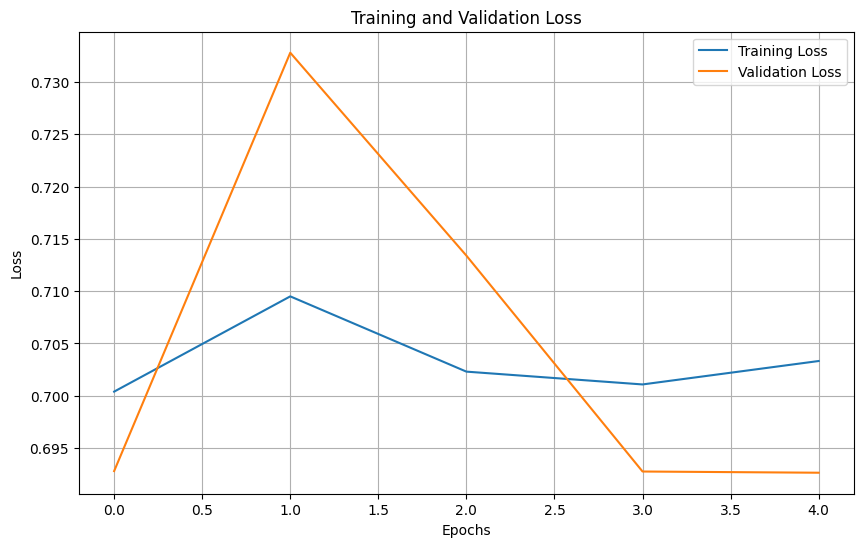

In [104]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses_lemm, label='Training Loss')
plt.plot(val_losses_lemm, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


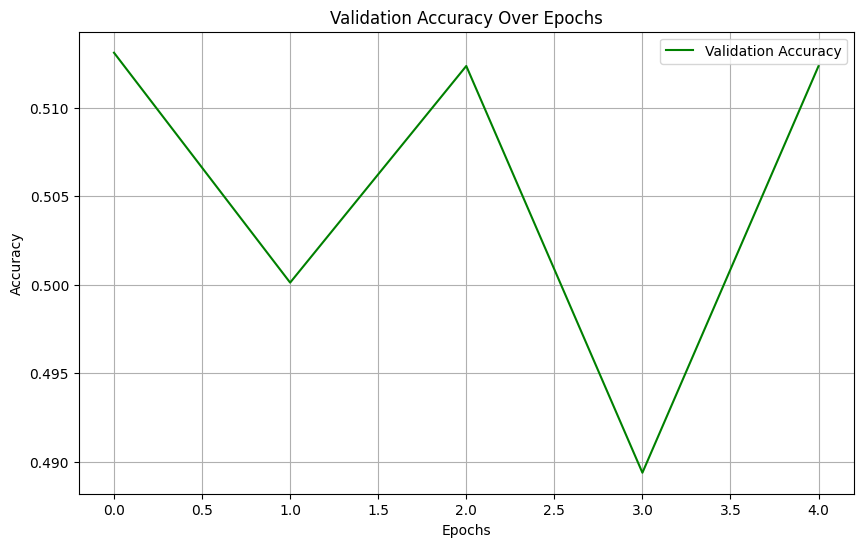

In [105]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(val_acc_lemm, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


#### 1.3 In the Model class, experiment with only picking the last output and mean of all outputs in the RNN layer. What changes do you observe ?

In [109]:
import torch
import torch.nn as nn

class RNNModel_last(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(RNNModel_last, self).__init__()
        # Define the layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Run forward pass through the model
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        # Pick the last output
        output = output[:, -1, :]
        logits = self.fc(output)
        return logits
train_ds_last = IMDBDataset_lemm(imdb_dataset["train"]["text"],imdb_dataset["train"]["label"], word2idx_lemm, minlen=100, maxlen=500)

# Create the validation dataset using the word2idx dictionary built using the train set
valid_ds_last = IMDBDataset_lemm(imdb_dataset["valid"]["text"],imdb_dataset["valid"]["label"], word2idx_lemm, minlen=100, maxlen=500)

# Create the test dataset using the word2idx dictionary built using the train set
test_ds_last = IMDBDataset_lemm(imdb_dataset["test"]["text"],imdb_dataset["test"]["label"], word2idx_lemm, minlen=100, maxlen=500)
train_loader_last = DataLoader(train_ds_last, batch_size=32, shuffle=True)
val_loader_last = DataLoader(valid_ds_last, batch_size=32, shuffle=False)
test_loader_last = DataLoader(test_ds_last, batch_size=32, shuffle=False)
    
model_last = RNNModel_last(vocab_size=vocab_size_lemm, hidden_size=hidden_size, embedding_dim=embedding_dim, num_classes=2)
model_last.to(device)  

optimizer_last = optim.Adam(model_last.parameters(), lr=learning_rate)
criterion_last = nn.CrossEntropyLoss()
print(model_last)

train_losses_last, val_losses_last, val_accuracies_last,val_acc_last,best_model_state_dict_last = train_model(
    model=model_last,
    train_loader=train_loader_last,
    valid_loader=val_loader_last,
    criterion=criterion_last,
    optimizer=optimizer_last,
    device=device,
    epochs=epochs
)


test_accuracy_last = test_model(
    model=model_last,
    test_loader=test_loader_last,
    criterion=criterion_last,
    device=device
)

Processing Reviews: 100%|██████████| 25000/25000 [02:40<00:00, 155.80it/s]


RNNModel_last(
  (embedding): Embedding(39587, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


Validation: 100%|██████████| 126/126 [00:00<00:00, 315.07it/s]


Epoch 1/5, Train Loss: 0.7001, Validation Loss: 0.6928, Validation Accuracy: 0.5116


Validation: 100%|██████████| 126/126 [00:00<00:00, 313.79it/s]


Epoch 2/5, Train Loss: 0.6986, Validation Loss: 0.7175, Validation Accuracy: 0.4881


Validation: 100%|██████████| 126/126 [00:00<00:00, 305.68it/s]


Epoch 3/5, Train Loss: 0.7025, Validation Loss: 0.7011, Validation Accuracy: 0.5124


Validation: 100%|██████████| 126/126 [00:00<00:00, 316.01it/s]


Epoch 4/5, Train Loss: 0.6999, Validation Loss: 0.7036, Validation Accuracy: 0.5124


Validation: 100%|██████████| 126/126 [00:00<00:00, 309.65it/s]


Epoch 5/5, Train Loss: 0.7065, Validation Loss: 0.6937, Validation Accuracy: 0.4886


Testing: 100%|██████████| 628/628 [00:01<00:00, 315.71it/s]

Test Loss: 0.6937, Test Accuracy: 0.4904


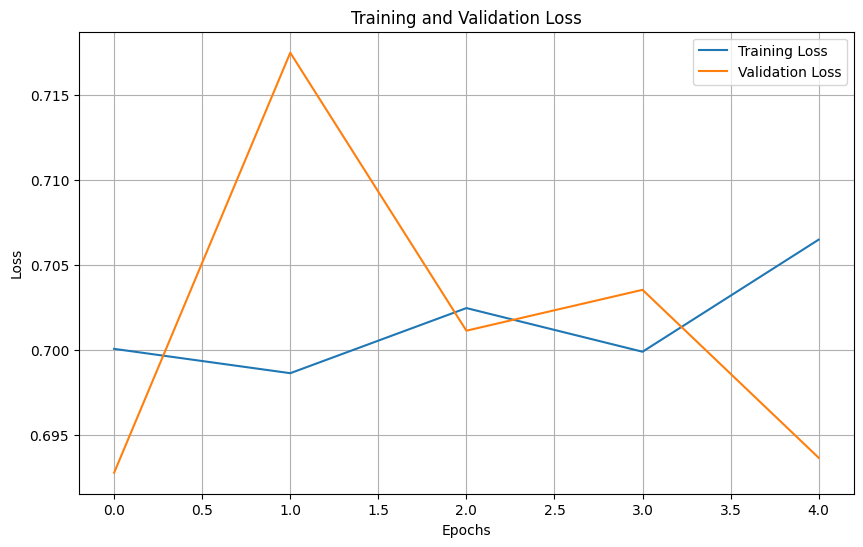

In [110]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses_last, label='Training Loss')
plt.plot(val_losses_last, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

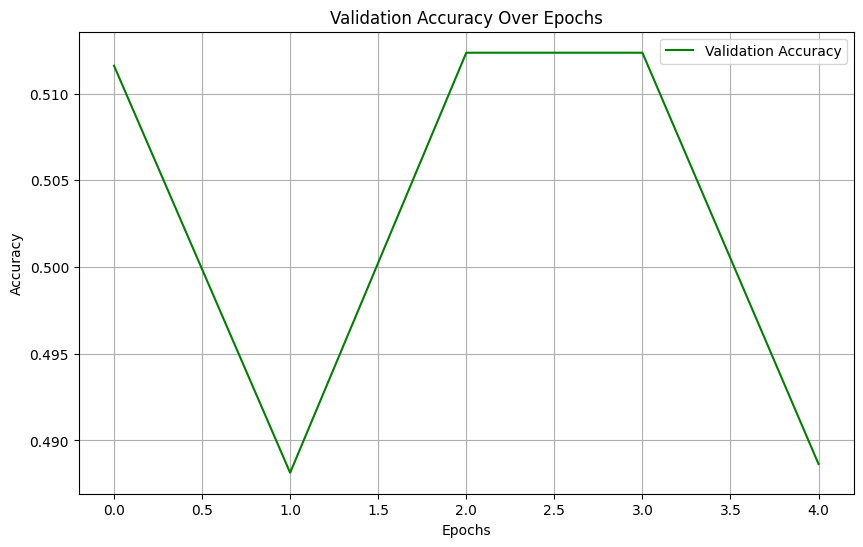

In [111]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(val_acc_last, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [118]:
class RNNModel_mean(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(RNNModel_mean, self).__init__()
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_size, out_features=num_classes)

    def forward(self, X):
        embedded = self.embedding(X) 
        output, hidden = self.rnn(embedded) 
        mean_output = output.mean(dim=1)
        logits = self.fc(mean_output)
        return logits

train_ds_mean = IMDBDataset_lemm(imdb_dataset["train"]["text"],imdb_dataset["train"]["label"], word2idx_lemm, minlen=100, maxlen=500)

# Create the validation dataset using the word2idx dictionary built using the train set
valid_ds_mean = IMDBDataset_lemm(imdb_dataset["valid"]["text"],imdb_dataset["valid"]["label"], word2idx_lemm, minlen=100, maxlen=500)

# Create the test dataset using the word2idx dictionary built using the train set
test_ds_mean = IMDBDataset_lemm(imdb_dataset["test"]["text"],imdb_dataset["test"]["label"], word2idx_lemm, minlen=100, maxlen=500)
train_loader_mean = DataLoader(train_ds_mean, batch_size=32, shuffle=True)
val_loader_mean = DataLoader(valid_ds_mean, batch_size=32, shuffle=False)
test_loader_mean = DataLoader(test_ds_mean, batch_size=32, shuffle=False)
    
model_mean = RNNModel_mean(vocab_size=vocab_size_lemm, hidden_size=hidden_size, embedding_dim=embedding_dim, num_classes=2)
model_mean.to(device)  

optimizer_mean = optim.Adam(model_mean.parameters(), lr=learning_rate)
criterion_mean = nn.CrossEntropyLoss()
print(model_mean)

train_losses_mean, val_losses_mean, val_accuracies_mean,val_acc_mean,best_model_state_dict_mean = train_model(
    model=model_mean,
    train_loader=train_loader_mean,
    valid_loader=val_loader_mean,
    criterion=criterion_mean,
    optimizer=optimizer_mean,
    device=device,
    epochs=epochs
)


test_accuracy_mean = test_model(
    model=model_mean,
    test_loader=test_loader_mean,
    criterion=criterion_mean,
    device=device
)    



Processing Reviews: 100%|██████████| 25000/25000 [02:47<00:00, 149.67it/s]


RNNModel_mean(
  (embedding): Embedding(39587, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


Validation: 100%|██████████| 126/126 [00:00<00:00, 294.67it/s]


Epoch 1/5, Train Loss: 0.6143, Validation Loss: 0.4649, Validation Accuracy: 0.7900


Validation: 100%|██████████| 126/126 [00:00<00:00, 299.04it/s]


Epoch 2/5, Train Loss: 0.5110, Validation Loss: 0.4799, Validation Accuracy: 0.7808


Validation: 100%|██████████| 126/126 [00:00<00:00, 297.90it/s]


Epoch 3/5, Train Loss: 0.5349, Validation Loss: 0.4812, Validation Accuracy: 0.8172


Validation: 100%|██████████| 126/126 [00:00<00:00, 297.24it/s]


Epoch 4/5, Train Loss: 0.3767, Validation Loss: 0.3761, Validation Accuracy: 0.8417


Validation: 100%|██████████| 126/126 [00:00<00:00, 299.25it/s]


Epoch 5/5, Train Loss: 0.2962, Validation Loss: 0.3500, Validation Accuracy: 0.8579


Testing: 100%|██████████| 628/628 [00:02<00:00, 300.57it/s]

Test Loss: 0.3907, Test Accuracy: 0.8301


## Mean RNN gives more better accuracy than the Last RNN
##

The mean of all outputs in an RNN (Recurrent Neural Network) can be more useful than picking only the last output in several scenarios:

1. **Long Sequences**: When dealing with long sequences, the information captured in the intermediate states of the RNN can be crucial for understanding the context. Taking the mean of all outputs allows the model to aggregate information from across the entire sequence, providing a more comprehensive representation of the input.

2. **Variable Length Sequences**: In tasks where sequences have variable lengths, taking the mean of all outputs ensures that each input sequence contributes equally to the final representation. This approach helps mitigate the impact of sequence length variability and ensures that the model can handle inputs of different lengths effectively.



### 2. Hyperparameter Tuning
#### 2.1 Starting with the best configurations based on the above experiments, experiment with 5 different hyperparameter configurations. You can change the size of embedding layer, hidden state, batch in the dataloader.


In [116]:
hyperparameter_configurations = [
    {'embedding_dim': 100, 'hidden_size': 128, 'batch_size': 32},
    {'embedding_dim': 200, 'hidden_size': 256, 'batch_size': 64},
    {'embedding_dim': 300, 'hidden_size': 512, 'batch_size': 128},
    {'embedding_dim': 150, 'hidden_size': 64, 'batch_size': 32},
    {'embedding_dim': 250, 'hidden_size': 128, 'batch_size': 64}
]


best_config_accuracy = 0
best_config = None
best_model_state = None
results = []

for config in hyperparameter_configurations:
    model_hyper = RNNModel_mean(vocab_size=vocab_size_lemm,hidden_size=config["hidden_size"],
                     embedding_dim=config["embedding_dim"], num_classes=2).to(device)
    optimizer_hyper = optim.Adam(model_hyper.parameters())
    criterion_hyper = nn.CrossEntropyLoss()
    train_ds_hyper = IMDBDataset_lemm(imdb_dataset["train"]["text"],imdb_dataset["train"]["label"], word2idx_lemm, minlen=100, maxlen=500)

    # Create the validation dataset using the word2idx dictionary built using the train set
    valid_ds_hyper = IMDBDataset_lemm(imdb_dataset["valid"]["text"],imdb_dataset["valid"]["label"], word2idx_lemm, minlen=100, maxlen=500)

    # Create the test dataset using the word2idx dictionary built using the train set
    test_ds_hyper = IMDBDataset_lemm(imdb_dataset["test"]["text"],imdb_dataset["test"]["label"], word2idx_lemm, minlen=100, maxlen=500)
    train_loader_hyper = DataLoader(train_ds_hyper, batch_size=config["batch_size"], shuffle=True)
    val_loader_hyper = DataLoader(valid_ds_hyper, batch_size=config["batch_size"], shuffle=False)
    test_loader_hyper = DataLoader(test_ds_hyper, batch_size=config["batch_size"], shuffle=False)
    train_losses_hyper, val_losses_hyper, val_accuracies_hyper,val_acc_hyper, best_model_state_dict_hyper= train_model(
    model=model_hyper,
    train_loader=train_loader_hyper,
    valid_loader=val_loader_hyper,
    criterion=criterion_hyper,
    optimizer=optimizer_hyper,
    device=device,
    epochs=epochs
   )


    current_config_accuracy = val_accuracies_hyper

    if current_config_accuracy > best_config_accuracy:
       best_config = config
       best_model =  RNNModel_mean(vocab_size=vocab_size_lemm, hidden_size=best_config["hidden_size"],
                            embedding_dim=best_config["embedding_dim"], num_classes=2).to(device)

        
train_ds_best = IMDBDataset_lemm(imdb_dataset["train"]["text"],imdb_dataset["train"]["label"], word2idx_lemm, minlen=100, maxlen=500)

    # Create the validation dataset using the word2idx dictionary built using the train set
valid_ds_best = IMDBDataset_lemm(imdb_dataset["valid"]["text"],imdb_dataset["valid"]["label"], word2idx_lemm, minlen=100, maxlen=500)

    # Create the test dataset using the word2idx dictionary built using the train set
test_ds_best = IMDBDataset_lemm(imdb_dataset["test"]["text"],imdb_dataset["test"]["label"], word2idx_lemm, minlen=100, maxlen=500)
train_loader_best = DataLoader(train_ds_best, batch_size=config["batch_size"], shuffle=True)
val_loader_best = DataLoader(valid_ds_best, batch_size=config["batch_size"], shuffle=False)
test_loader_best = DataLoader(test_ds_best, batch_size=config["batch_size"], shuffle=False)
        

#model_mean = RNNModel_mean(vocab_size=vocab_size_lemm, hidden_size=hidden_size, embedding_dim=embedding_dim, num_classes=2)
best_model.to(device)
optimizer_best = optim.Adam(best_model.parameters(), lr=learning_rate)
criterion_best = nn.CrossEntropyLoss()
print(best_model)
train_losses_best, val_losses_best, val_accuracies_best,val_acc_best,best_model_state_dict_best = train_model(
    model=best_model,
    train_loader=train_loader_best,
    valid_loader=val_loader_best,
    criterion=criterion_best,
    optimizer=optimizer_best,
    device=device,
    epochs=epochs
   )

test_accuracy = test_model(
    model=best_model,
    test_loader=test_loader_best,
    criterion=criterion_best,
    device=device
)    
print("TEST ACCURACY")
print(test_accuracy)

Validation: 100%|██████████| 126/126 [00:00<00:00, 510.74it/s]


Epoch 1/5, Train Loss: 0.6403, Validation Loss: 0.5697, Validation Accuracy: 0.7276


Validation: 100%|██████████| 126/126 [00:00<00:00, 522.82it/s]


Epoch 2/5, Train Loss: 0.5203, Validation Loss: 0.4398, Validation Accuracy: 0.8045


Validation: 100%|██████████| 126/126 [00:00<00:00, 511.06it/s]


Epoch 3/5, Train Loss: 0.4213, Validation Loss: 0.3914, Validation Accuracy: 0.8375


Validation: 100%|██████████| 126/126 [00:00<00:00, 527.44it/s]


Epoch 4/5, Train Loss: 0.2950, Validation Loss: 0.3688, Validation Accuracy: 0.8507


Validation: 100%|██████████| 126/126 [00:00<00:00, 513.79it/s]


Epoch 5/5, Train Loss: 0.2283, Validation Loss: 0.3906, Validation Accuracy: 0.8554


Validation: 100%|██████████| 63/63 [00:00<00:00, 179.46it/s]


Epoch 1/5, Train Loss: 0.6902, Validation Loss: 0.6666, Validation Accuracy: 0.6866


Validation: 100%|██████████| 63/63 [00:00<00:00, 180.89it/s]


Epoch 2/5, Train Loss: 0.5213, Validation Loss: 0.4793, Validation Accuracy: 0.8282


Validation: 100%|██████████| 63/63 [00:00<00:00, 182.82it/s]


Epoch 3/5, Train Loss: 0.5998, Validation Loss: 0.6702, Validation Accuracy: 0.6984


Validation: 100%|██████████| 63/63 [00:00<00:00, 177.40it/s]


Epoch 4/5, Train Loss: 0.6588, Validation Loss: 0.6475, Validation Accuracy: 0.8255


Validation: 100%|██████████| 63/63 [00:00<00:00, 180.27it/s]


Epoch 5/5, Train Loss: 0.6244, Validation Loss: 0.6313, Validation Accuracy: 0.6849


Validation: 100%|██████████| 32/32 [00:00<00:00, 43.37it/s]


Epoch 1/5, Train Loss: 0.6964, Validation Loss: 0.6589, Validation Accuracy: 0.5970


Validation: 100%|██████████| 32/32 [00:00<00:00, 43.48it/s]


Epoch 2/5, Train Loss: 0.7701, Validation Loss: 0.6897, Validation Accuracy: 0.5633


Validation: 100%|██████████| 32/32 [00:00<00:00, 42.89it/s]


Epoch 3/5, Train Loss: 0.6887, Validation Loss: 0.6755, Validation Accuracy: 0.5733


Validation: 100%|██████████| 32/32 [00:00<00:00, 42.53it/s]


Epoch 4/5, Train Loss: 0.6613, Validation Loss: 0.6035, Validation Accuracy: 0.6539


Validation: 100%|██████████| 32/32 [00:00<00:00, 42.18it/s]


Epoch 5/5, Train Loss: 0.5676, Validation Loss: 0.4994, Validation Accuracy: 0.7900


Validation: 100%|██████████| 126/126 [00:00<00:00, 510.01it/s]


Epoch 1/5, Train Loss: 0.6102, Validation Loss: 0.4929, Validation Accuracy: 0.7750


Validation: 100%|██████████| 126/126 [00:00<00:00, 550.18it/s]


Epoch 2/5, Train Loss: 0.4237, Validation Loss: 0.3859, Validation Accuracy: 0.8402


Validation: 100%|██████████| 126/126 [00:00<00:00, 544.32it/s]


Epoch 3/5, Train Loss: 0.3427, Validation Loss: 0.3636, Validation Accuracy: 0.8519


Validation: 100%|██████████| 126/126 [00:00<00:00, 544.21it/s]


Epoch 4/5, Train Loss: 0.2635, Validation Loss: 0.3978, Validation Accuracy: 0.8427


Validation: 100%|██████████| 126/126 [00:00<00:00, 532.24it/s]


Epoch 5/5, Train Loss: 0.2157, Validation Loss: 0.3360, Validation Accuracy: 0.8669


Validation: 100%|██████████| 63/63 [00:00<00:00, 365.56it/s]


Epoch 1/5, Train Loss: 0.5987, Validation Loss: 0.4716, Validation Accuracy: 0.7888


Validation: 100%|██████████| 63/63 [00:00<00:00, 365.55it/s]


Epoch 2/5, Train Loss: 0.4454, Validation Loss: 0.4845, Validation Accuracy: 0.7790


Validation: 100%|██████████| 63/63 [00:00<00:00, 369.01it/s]


Epoch 3/5, Train Loss: 0.3515, Validation Loss: 0.3889, Validation Accuracy: 0.8424


Validation: 100%|██████████| 63/63 [00:00<00:00, 367.31it/s]


Epoch 4/5, Train Loss: 0.2535, Validation Loss: 0.3506, Validation Accuracy: 0.8622


Validation: 100%|██████████| 63/63 [00:00<00:00, 362.89it/s]


Epoch 5/5, Train Loss: 0.1997, Validation Loss: 0.3861, Validation Accuracy: 0.8564


Processing Reviews: 100%|██████████| 25000/25000 [02:47<00:00, 149.59it/s]


RNNModel_mean(
  (embedding): Embedding(39587, 250)
  (rnn): RNN(250, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


Validation: 100%|██████████| 63/63 [00:00<00:00, 360.45it/s]


Epoch 1/5, Train Loss: 0.6011, Validation Loss: 0.4827, Validation Accuracy: 0.7840


Validation: 100%|██████████| 63/63 [00:00<00:00, 371.46it/s]


Epoch 2/5, Train Loss: 0.4201, Validation Loss: 0.4017, Validation Accuracy: 0.8240


Validation: 100%|██████████| 63/63 [00:00<00:00, 351.76it/s]


Epoch 3/5, Train Loss: 0.3141, Validation Loss: 0.3584, Validation Accuracy: 0.8517


Validation: 100%|██████████| 63/63 [00:00<00:00, 364.54it/s]


Epoch 4/5, Train Loss: 0.2656, Validation Loss: 0.3638, Validation Accuracy: 0.8512


Validation: 100%|██████████| 63/63 [00:00<00:00, 363.28it/s]


Epoch 5/5, Train Loss: 0.2323, Validation Loss: 0.3858, Validation Accuracy: 0.8509


Testing: 100%|██████████| 314/314 [00:00<00:00, 361.37it/s]

Test Loss: 0.4159, Test Accuracy: 0.8305
TEST ACCURACY
(0.41594433057758246, 0.8305110070724175)


### 3. After RNNs
#### 3.1 Keeping all the parameters same, replace the RNN layer with the LSTM layer using nn.LSTM. What changes do you observe ? Explain why LSTM layer would affect performance.

In [117]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(LSTMModel, self).__init__()
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_size, out_features=num_classes)

    def forward(self, X):
        embedded = self.embedding(X) 
        output, (hidden, cell) = self.lstm(embedded) 
        mean_output = output.mean(dim=1)
        logits = self.fc(mean_output)
        return logits


    
train_ds_lstm = IMDBDataset_lemm(imdb_dataset["train"]["text"],imdb_dataset["train"]["label"], word2idx_lemm, minlen=100, maxlen=500)

    # Create the validation dataset using the word2idx dictionary built using the train set
valid_ds_lstm = IMDBDataset_lemm(imdb_dataset["valid"]["text"],imdb_dataset["valid"]["label"], word2idx_lemm, minlen=100, maxlen=500)

    # Create the test dataset using the word2idx dictionary built using the train set
test_ds_lstm = IMDBDataset_lemm(imdb_dataset["test"]["text"],imdb_dataset["test"]["label"], word2idx_lemm, minlen=100, maxlen=500)
train_loader_lstm = DataLoader(train_ds_lstm, batch_size=best_config["batch_size"], shuffle=True)
val_loader_lstm = DataLoader(valid_ds_lstm, batch_size=best_config["batch_size"], shuffle=False)
test_loader_lstm = DataLoader(test_ds_lstm, batch_size=best_config["batch_size"], shuffle=False)
            

model_lstm = LSTMModel(vocab_size=vocab_size_lemm, hidden_size=best_config["hidden_size"],
                       embedding_dim=best_config["embedding_dim"], num_classes=2).to(device)
model_lstm.to(device)
optimizer_lstm = optim.Adam(model_lstm.parameters(),lr=learning_rate)
criterion_lstm = nn.CrossEntropyLoss()


train_losses_lstm, val_losses_lstm, val_accuracies_lstm, val_acc_lstm,best_model_state_dict_lstm = train_model(
    model=model_lstm,
    train_loader=train_loader_lstm,
    valid_loader=val_loader_lstm,
    criterion=criterion_lstm,
    optimizer=optimizer_lstm,
    device=device,
    epochs=epochs
   )
test_accuracy_lstm = test_model(
    model=model_lstm,
    test_loader=test_loader_lstm,
    criterion=criterion_lstm,
    device=device
)    
print("LSTM Test Accuracy:", test_accuracy_lstm)



Validation: 100%|██████████| 63/63 [00:00<00:00, 142.35it/s]


Epoch 1/5, Train Loss: 0.6048, Validation Loss: 0.4577, Validation Accuracy: 0.7980


Validation: 100%|██████████| 63/63 [00:00<00:00, 141.32it/s]


Epoch 2/5, Train Loss: 0.3647, Validation Loss: 0.3734, Validation Accuracy: 0.8464


Validation: 100%|██████████| 63/63 [00:00<00:00, 141.75it/s]


Epoch 3/5, Train Loss: 0.2490, Validation Loss: 0.3168, Validation Accuracy: 0.8717


Validation: 100%|██████████| 63/63 [00:00<00:00, 141.26it/s]


Epoch 4/5, Train Loss: 0.1608, Validation Loss: 0.3080, Validation Accuracy: 0.8836


Validation: 100%|██████████| 63/63 [00:00<00:00, 139.46it/s]


Epoch 5/5, Train Loss: 0.1048, Validation Loss: 0.3644, Validation Accuracy: 0.8749


Testing: 100%|██████████| 314/314 [00:02<00:00, 139.76it/s]

Test Loss: 0.4051, Test Accuracy: 0.8515
LSTM Test Accuracy: (0.4051390481501037, 0.8514792309991035)


Replacing an RNN layer with an LSTM layer can have several effects on the performance of a neural network model. LSTM (Long Short-Term Memory) is a type of recurrent neural network architecture that is specifically designed to overcome the vanishing gradient problem and better capture long-term dependencies in sequential data. Here are some potential changes and reasons for the performance differences:

1. **Improved Long-Term Dependency Handling**: LSTM networks have a more sophisticated memory cell structure compared to simple RNNs. 

2. **Reduced Vanishing Gradient Problem**: The standard RNN architecture suffers from the vanishing gradient problem, where gradients diminish as they propagate back through time during training. LSTMs address this issue by introducing gated mechanisms (such as input, forget, and output gates) that control the flow of information within the cell. 

3. **Increased Model Complexity**: LSTMs are more complex than simple RNNs due to their additional gating mechanisms and memory cells. This increased complexity may lead to longer training times and higher computational costs. However, this complexity often pays off in terms of improved performance, especially for tasks that require capturing long-range dependencies.

Overall, replacing an RNN layer with an LSTM layer can lead to improvements in performance, particularly in tasks involving long sequences or where capturing long-range dependencies is crucial. However, it's essential to experiment with different architectures and hyperparameters to find the optimal model for a specific task.